In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import torch # framework
import torch.nn as nn # neural net framework
import torchvision # dataset
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt # data visualization
from torchvision import transforms

In [3]:
# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyperparamters = config of the model
input_size = 784 # images are 28x28
hidden_size = 100
num_classes = 10 # 0-9 digits
num_epochs = 50
batch_size = 100
learning_rate = 0.001

In [4]:
class DigitRecogDataset(Dataset):
    def __init__(self,csv_file,has_labels=True,transform=None):
        self.data = pd.read_csv(csv_file)
        self.has_labels = has_labels
        self.transform = transform

        if self.has_labels:
            # The first column of train.csv has labels for data
            self.labels = self.data.iloc[:,0].values
            self.images = self.data.iloc[:,1:].values
        else:
            # The test.csv does not contain a label
            self.images = self.data.values

    def __len__(self):
        return len(self.images)

    def __getitem__(self,index):
        image = self.images[index].reshape(28,28).astype('float32')/255.0
        image = torch.tensor(image).unsqueeze(0) # (1,28,28)

        if self.transform:
            image = self.transform(image)

        if self.has_labels:
            label = torch.tensor(self.labels[index],dtype=torch.long)
            return image, label
        else:
            return image

import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Normalize((0.5,), (0.5,))  # normalize pixel values
])

In [5]:
# Dataset
from torch.utils.data import random_split, DataLoader

test_ds = DigitRecogDataset(
    csv_file="/kaggle/input/digit-recognizer/test.csv",
    has_labels=False,
    transform=transform
)
train_ds = DigitRecogDataset(
    csv_file="/kaggle/input/digit-recognizer/train.csv",
    has_labels=True,
    transform=transform
)

#split train_ds into a sperate validation set (val_ds)
#currently set to [10%] to give more data for training
val_frac = 0.1
n_val = int(len(train_ds) * val_frac)
n_train = len(train_ds) - n_val
train_ds, val_ds = random_split(train_ds, [n_train, n_val])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds,batch_size=batch_size,shuffle=False)

torch.Size([100, 1, 28, 28]) torch.Size([100])


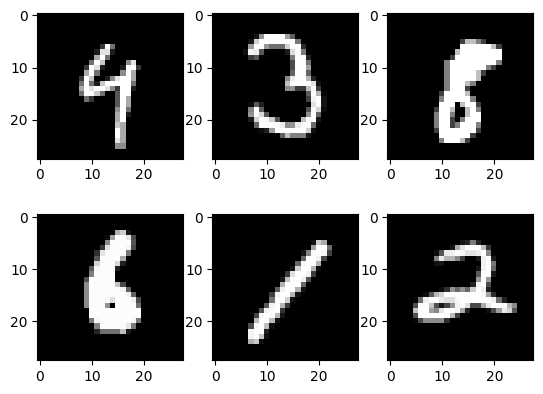

In [6]:
# visualize
examples = iter(train_loader)
samples, labels = next(examples) # torch objects have the samples and labels atributes
print(samples.shape, labels.shape)

# torch.Size([100, 1, 28, 28]) torch.Size([100])
# 100 samples, 1 channel of color, 28 width, 28 length
# Each class label has one value

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(samples[i][0], cmap='gray')
plt.show()

In [7]:
class NeuralNet(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(NeuralNet, self).__init__()
    self.l1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.l2 = nn.Linear(hidden_size, num_classes)

  def forward(self,x):
    out = self.l1(x)
    out = self.relu(out)
    out = self.l2(out)
    return out

model = NeuralNet(input_size, hidden_size, num_classes)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss() # applies softmax automatically
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) # optim paramters at learning rate
model.to(device) # move model to device

NeuralNet(
  (l1): Linear(in_features=784, out_features=100, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=100, out_features=10, bias=True)
)

In [8]:
# Training Loop

n_steps = len(train_loader)
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    # [100, 1, 28, 28] --> [100, 784]
    images = images.reshape(-1, 28*28).to(device) # -1 forces pytoch to automatically find the dimension
    labels = labels.to(device)

    # forward
    outputs = model(images)
    loss = criterion(outputs, labels) # predicted, actual

    # backward
    optimizer.zero_grad() # empty gradients
    loss.backward() # backpropagation
    optimizer.step()

    if (i+1) % 100 == 0:
      print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{n_steps}, loss = {loss.item():.4f}')

epoch 1 / 50, step 100/378, loss = 0.4943
epoch 1 / 50, step 200/378, loss = 0.1639
epoch 1 / 50, step 300/378, loss = 0.1862
epoch 2 / 50, step 100/378, loss = 0.1691
epoch 2 / 50, step 200/378, loss = 0.1949
epoch 2 / 50, step 300/378, loss = 0.2634
epoch 3 / 50, step 100/378, loss = 0.3951
epoch 3 / 50, step 200/378, loss = 0.1905
epoch 3 / 50, step 300/378, loss = 0.1345
epoch 4 / 50, step 100/378, loss = 0.1298
epoch 4 / 50, step 200/378, loss = 0.2225
epoch 4 / 50, step 300/378, loss = 0.0611
epoch 5 / 50, step 100/378, loss = 0.0692
epoch 5 / 50, step 200/378, loss = 0.1413
epoch 5 / 50, step 300/378, loss = 0.0544
epoch 6 / 50, step 100/378, loss = 0.0876
epoch 6 / 50, step 200/378, loss = 0.1773
epoch 6 / 50, step 300/378, loss = 0.1345
epoch 7 / 50, step 100/378, loss = 0.1101
epoch 7 / 50, step 200/378, loss = 0.0786
epoch 7 / 50, step 300/378, loss = 0.0964
epoch 8 / 50, step 100/378, loss = 0.0782
epoch 8 / 50, step 200/378, loss = 0.1433
epoch 8 / 50, step 300/378, loss =

In [9]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in val_loader:
        # handle 2- or 3-tuple batches robustly
        if isinstance(batch, (list, tuple)):
            images, labels = batch[0], batch[1]
        else:
            raise RuntimeError("Unexpected batch type; expected tuple/list")

        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print(f"Validation accuracy: {100 * correct / total:.2f}%")


Validation accuracy: 97.36%


In [10]:
# Model Submission

model.eval()
predictions = []
with torch.no_grad():
    for images in test_loader:
        images = images.reshape(-1,28*28).to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

submission = pd.DataFrame({
    "ImageID": range(1, len(predictions)+1),
    "Label": predictions
})

submission.to_csv("submission.csv", index=False)